## SETUP INICIAL - Instalar librerias y configurar Google Colab

In [1]:
# Instalar librerias necesarias
!pip install -q scikit-learn pandas numpy matplotlib seaborn

In [2]:
# Importar librerias
import pandas as pd
import numpy as np
import os
import pickle
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score,
    roc_curve, auc
)

warnings.filterwarnings('ignore')

# Configurar visualizaciones
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("[OK] Librerias importadas exitosamente")

[OK] Librerias importadas exitosamente


In [3]:
# Configurar Google Colab (si aplica)
from google.colab import files
import shutil

print("[OK] Google Colab configurado")
print("\nINSTRUCCIONES PARA COLAB:")
print("1. Si tienes el archivo CSV localmente, ejecuta: files.upload()")
print("2. O copia el CSV a tu Google Drive y usa:")
print("   from google.colab import drive")
print("   drive.mount('/content/drive')")
print("3. Luego actualiza dataset_path a la ubicacion correcta")

[OK] Google Colab configurado

INSTRUCCIONES PARA COLAB:
1. Si tienes el archivo CSV localmente, ejecuta: files.upload()
2. O copia el CSV a tu Google Drive y usa:
   from google.colab import drive
   drive.mount('/content/drive')
3. Luego actualiza dataset_path a la ubicacion correcta


---
# FASE 1: SAMPLE - Cargar y verificar datos
### Objetivo: Cargar dataset original y validar estructura

In [6]:
print("\n" + "="*80)
print("FASE 1: SAMPLE - Cargar Dataset")
print("="*80)
print("Objetivo: Cargar 9,312 muestras del dataset CyberNative DPO")


dataset_path = '/content/cybernative_detector_training.csv'

print(f"\nCargando dataset desde: {dataset_path}")

try:
    df = pd.read_csv(dataset_path)
    print(f"[OK] Dataset cargado exitosamente")
except FileNotFoundError:
    print(f"[ERROR] Archivo no encontrado: {dataset_path}")
    print("Por favor ajusta la ruta dataset_path")
    df = None


FASE 1: SAMPLE - Cargar Dataset
Objetivo: Cargar 9,312 muestras del dataset CyberNative DPO

Cargando dataset desde: /content/cybernative_detector_training.csv
[OK] Dataset cargado exitosamente


In [7]:
# Validar estructura del dataset
print(f"\nTotal registros: {len(df):,}")
print(f"Total columnas: {df.shape[1]}")
print(f"\nColumnas: {list(df.columns)}")

# Verificar columnas requeridas
required_cols = ['codigo', 'lenguaje', 'vulnerable']
missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    print(f"[ERROR] Faltan columnas: {missing_cols}")
else:
    print(f"[OK] Todas las columnas requeridas presentes")


Total registros: 9,312
Total columnas: 5

Columnas: ['codigo', 'lenguaje', 'tipo_vulnerabilidad', 'pregunta', 'vulnerable']
[OK] Todas las columnas requeridas presentes


In [8]:
# Analizar distribucion de clases
print("\nDistribucion de clases:")
class_counts = df['vulnerable'].value_counts()
for cls, count in class_counts.items():
    pct = (count / len(df)) * 100
    label = "Vulnerable" if cls == 1 else "Seguro"
    print(f"  - {label} ({cls}): {count:,} ({pct:.1f}%)")

# Analizar lenguajes
print(f"\nLenguajes en dataset: {df['lenguaje'].nunique()}")
print(f"Valores nulos totales: {df.isnull().sum().sum()}")
print(f"Duplicados: {df.duplicated().sum()}")

print("\n[OK] FASE 1 COMPLETADA")


Distribucion de clases:
  - Vulnerable (1): 4,656 (50.0%)
  - Seguro (0): 4,656 (50.0%)

Lenguajes en dataset: 11
Valores nulos totales: 0
Duplicados: 7

[OK] FASE 1 COMPLETADA


---
# FASE 2: EXPLORE - Analisis exploratorio
### Objetivo: Entender caracteristicas del dataset

In [9]:
print("\n" + "="*80)
print("FASE 2: EXPLORE - Analisis Estadistico")
print("="*80)

# Estadisticas de longitud de codigo
code_lengths = df['codigo'].str.len()
print(f"\nEstadisticas de longitud de codigo:")
print(f"  - Promedio: {code_lengths.mean():.0f} caracteres")
print(f"  - Mediana: {code_lengths.median():.0f} caracteres")
print(f"  - Minimo: {code_lengths.min()} caracteres")
print(f"  - Maximo: {code_lengths.max()} caracteres")
print(f"  - Desv. Est.: {code_lengths.std():.0f} caracteres")


FASE 2: EXPLORE - Analisis Estadistico

Estadisticas de longitud de codigo:
  - Promedio: 461 caracteres
  - Mediana: 369 caracteres
  - Minimo: 55 caracteres
  - Maximo: 8925 caracteres
  - Desv. Est.: 423 caracteres


In [10]:
# Distribucion de lenguajes
print(f"\nDistribucion de lenguajes:")
lang_dist = df['lenguaje'].value_counts()
for lang, count in lang_dist.items():
    pct = (count / len(df)) * 100
    print(f"  - {lang}: {count:,} ({pct:.1f}%)")


Distribucion de lenguajes:
  - c++: 848 (9.1%)
  - python: 848 (9.1%)
  - java: 848 (9.1%)
  - javascript: 848 (9.1%)
  - c#: 846 (9.1%)
  - php: 846 (9.1%)
  - ruby: 846 (9.1%)
  - swift: 846 (9.1%)
  - go: 846 (9.1%)
  - kotlin: 846 (9.1%)
  - fortran: 844 (9.1%)


In [11]:
# Balanceo de clases
vulnerable_count = (df['vulnerable'] == 1).sum()
safe_count = (df['vulnerable'] == 0).sum()
diff = abs(vulnerable_count - safe_count)

print(f"\nBalanceo de clases:")
print(f"  - Vulnerable: {vulnerable_count:,}")
print(f"  - Seguro: {safe_count:,}")
print(f"  - Diferencia: {diff} registros")
if diff < 100:
    print(f"  - Estado: BALANCEADO PERFECTO")
else:
    print(f"  - Estado: DESBALANCEADO")

print("\n[OK] FASE 2 COMPLETADA")


Balanceo de clases:
  - Vulnerable: 4,656
  - Seguro: 4,656
  - Diferencia: 0 registros
  - Estado: BALANCEADO PERFECTO

[OK] FASE 2 COMPLETADA


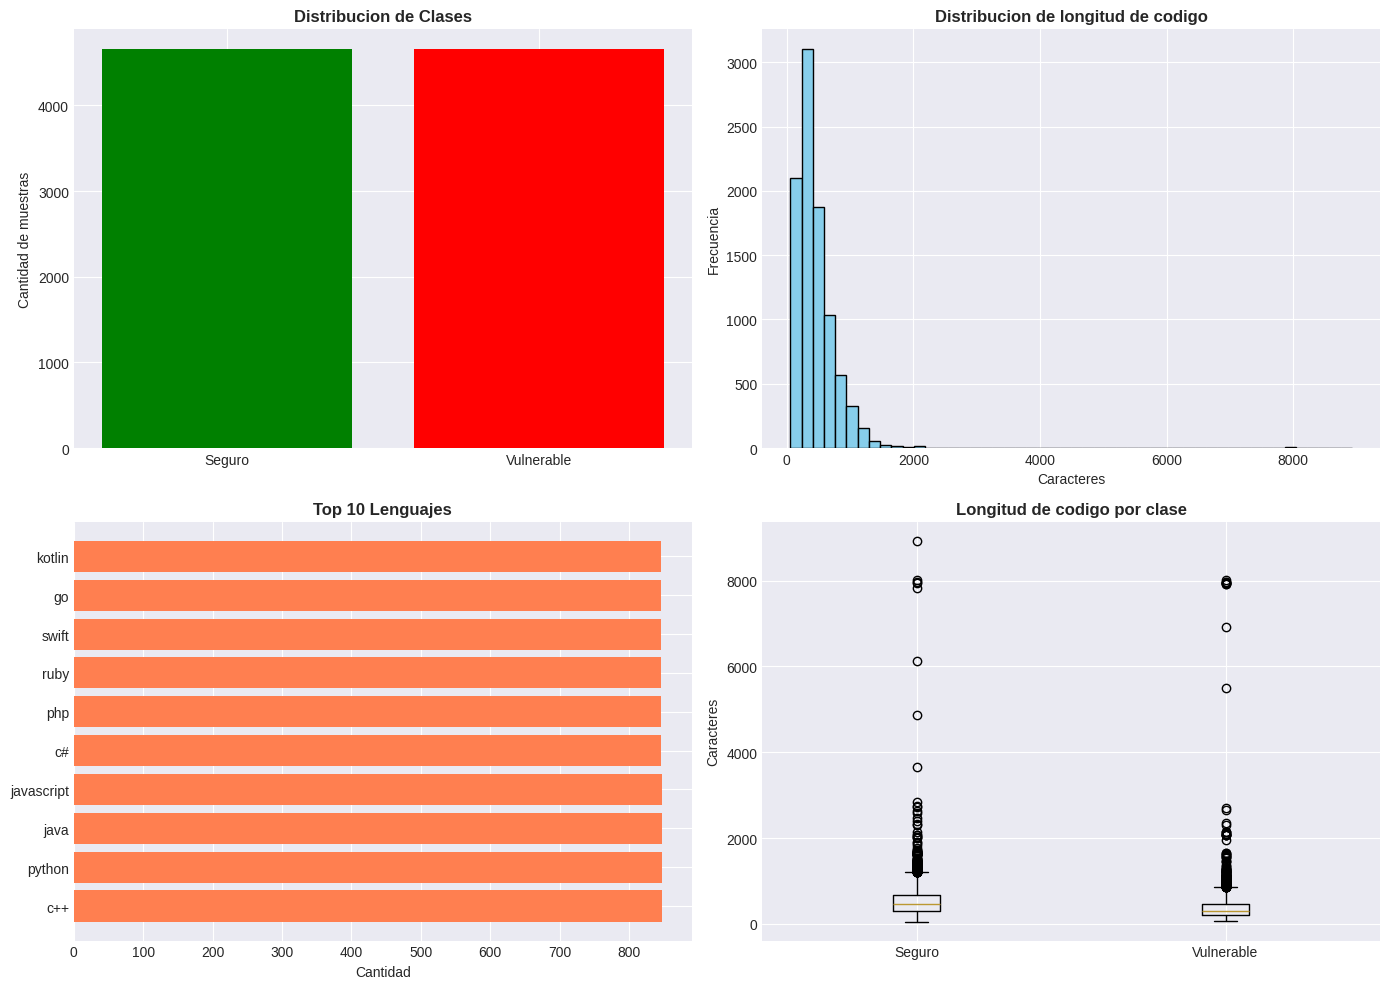

Graficas generadas exitosamente


In [12]:
# Visualizaciones
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Distribucion de clases
class_dist = df['vulnerable'].value_counts()
axes[0, 0].bar(['Seguro', 'Vulnerable'], [class_dist[0], class_dist[1]], color=['green', 'red'])
axes[0, 0].set_title('Distribucion de Clases', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Cantidad de muestras')

# Longitud de codigo
axes[0, 1].hist(code_lengths, bins=50, color='skyblue', edgecolor='black')
axes[0, 1].set_title('Distribucion de longitud de codigo', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Caracteres')
axes[0, 1].set_ylabel('Frecuencia')

# Top lenguajes
top_langs = lang_dist.head(10)
axes[1, 0].barh(top_langs.index, top_langs.values, color='coral')
axes[1, 0].set_title('Top 10 Lenguajes', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Cantidad')

# Longitud por clase
vulnerable_lengths = df[df['vulnerable'] == 1]['codigo'].str.len()
safe_lengths = df[df['vulnerable'] == 0]['codigo'].str.len()
axes[1, 1].boxplot([safe_lengths, vulnerable_lengths], labels=['Seguro', 'Vulnerable'])
axes[1, 1].set_title('Longitud de codigo por clase', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Caracteres')

plt.tight_layout()
plt.show()

print("Graficas generadas exitosamente")

---
# FASE 3: MODIFY - Feature Engineering
### Objetivo: Preparar features para el modelo

In [13]:
print("\n" + "="*80)
print("FASE 3: MODIFY - Feature Engineering")
print("="*80)

# Extraer X y y
X_code = df['codigo'].values
X_lang = df['lenguaje'].values
y = df['vulnerable'].values

print(f"\nExtrayendo features...")
print(f"  - Total muestras: {len(X_code):,}")
print(f"  - Target variable: 0=Seguro, 1=Vulnerable")


FASE 3: MODIFY - Feature Engineering

Extrayendo features...
  - Total muestras: 9,312
  - Target variable: 0=Seguro, 1=Vulnerable


In [14]:
# Vectorizacion TF-IDF
print("\nFeature Engineering - TF-IDF:")
print("  - Max features: 1000")
print("  - N-grams: (1, 2) - unigramas + bigramas")
print("  - Stop words: English")
print("  - Sublinear TF: True")
print("  - Min DF: 2, Max DF: 0.95")
print("  - Vectorizando codigo...")

tfidf_vectorizer = TfidfVectorizer(
    max_features=1000,
    ngram_range=(1, 2),
    lowercase=True,
    stop_words='english',
    sublinear_tf=True,
    min_df=2,
    max_df=0.95
)

X_tfidf = tfidf_vectorizer.fit_transform(X_code)
print(f"[OK] Matriz TF-IDF shape: {X_tfidf.shape}")


Feature Engineering - TF-IDF:
  - Max features: 1000
  - N-grams: (1, 2) - unigramas + bigramas
  - Stop words: English
  - Sublinear TF: True
  - Min DF: 2, Max DF: 0.95
  - Vectorizando codigo...
[OK] Matriz TF-IDF shape: (9312, 1000)


In [15]:
# Language Encoding
print("\nFeature Engineering - Language Encoding:")
lang_encoder = LabelEncoder()
X_lang_encoded = lang_encoder.fit_transform(X_lang)
print(f"  - Lenguajes unicos: {len(lang_encoder.classes_)}")
print(f"  - Lenguajes: {', '.join(lang_encoder.classes_)}")
print(f"[OK] Language encoding completado")


Feature Engineering - Language Encoding:
  - Lenguajes unicos: 11
  - Lenguajes: c#, c++, fortran, go, java, javascript, kotlin, php, python, ruby, swift
[OK] Language encoding completado


In [16]:
# Combinar features
X_tfidf_dense = X_tfidf.toarray()
X_combined = np.column_stack([X_tfidf_dense, X_lang_encoded])
print(f"\nFeatures combinados:")
print(f"  - TF-IDF features: {X_tfidf_dense.shape[1]}")
print(f"  - Language features: 1")
print(f"  - Total features: {X_combined.shape[1]}")
print(f"  - Total muestras: {X_combined.shape[0]:,}")


Features combinados:
  - TF-IDF features: 1000
  - Language features: 1
  - Total features: 1001
  - Total muestras: 9,312


In [17]:
# Train/Test split
print(f"\nDividiendo en train/test (80/20, stratified)...")
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"[OK] Split completado:")
print(f"  - Train: {len(X_train):,} muestras")
print(f"  - Test: {len(X_test):,} muestras")
print(f"  - Train class distribution: {np.bincount(y_train)}")
print(f"  - Test class distribution: {np.bincount(y_test)}")

print("\n[OK] FASE 3 COMPLETADA")


Dividiendo en train/test (80/20, stratified)...
[OK] Split completado:
  - Train: 7,449 muestras
  - Test: 1,863 muestras
  - Train class distribution: [3724 3725]
  - Test class distribution: [932 931]

[OK] FASE 3 COMPLETADA


---
# FASE 4: MODEL - Entrenar RandomForest
### Objetivo: Entrenar modelo de deteccion binaria

In [18]:
print("\n" + "="*80)
print("FASE 4: MODEL - Entrenar RandomForest")
print("="*80)

print("\nConfiguracion del modelo:")
print("  - Algoritmo: RandomForestClassifier")
print("  - N estimators: 200 arboles")
print("  - Max depth: 25")
print("  - Min samples split: 5")
print("  - Random state: 42")
print("  - N jobs: -1 (usar todos los cores)")

print("\nEntrenando modelo...")
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=25,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

model.fit(X_train, y_train)
print("[OK] Modelo entrenado exitosamente")

print("\n[OK] FASE 4 COMPLETADA")


FASE 4: MODEL - Entrenar RandomForest

Configuracion del modelo:
  - Algoritmo: RandomForestClassifier
  - N estimators: 200 arboles
  - Max depth: 25
  - Min samples split: 5
  - Random state: 42
  - N jobs: -1 (usar todos los cores)

Entrenando modelo...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    2.1s


[OK] Modelo entrenado exitosamente

[OK] FASE 4 COMPLETADA


[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    9.6s finished


---
# FASE 5: ASSESS - Evaluar performance
### Objetivo: Evaluar metricas, K-Fold y análisis detallado

In [19]:
print("\n" + "="*80)
print("FASE 5: ASSESS - Evaluar Performance")
print("="*80)

print("\nGenerando predicciones...")
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Metricas en train set
train_acc = accuracy_score(y_train, y_pred_train)
print(f"\nMETRICAS EN TRAIN SET:")
print(f"  - Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")


FASE 5: ASSESS - Evaluar Performance

Generando predicciones...


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s



METRICAS EN TRAIN SET:
  - Accuracy: 0.8581 (85.81%)


[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.1s finished


In [20]:
# K-Fold Cross-Validation
print("\nVALIDACION CRUZADA (5-Fold StratifiedKFold):")
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X_combined, y, cv=kfold, scoring='accuracy', n_jobs=-1)

for i, score in enumerate(cv_scores, 1):
    print(f"  - Fold {i}: {score:.4f}")
print(f"  - Promedio: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")


VALIDACION CRUZADA (5-Fold StratifiedKFold):
  - Fold 1: 0.7874
  - Fold 2: 0.7944
  - Fold 3: 0.7938
  - Fold 4: 0.7938
  - Fold 5: 0.7916
  - Promedio: 0.7922 (+/- 0.0026)


In [21]:
# Metricas en test set
test_acc = accuracy_score(y_test, y_pred_test)
precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"\nMETRICAS EN TEST SET:")
print(f"  - Accuracy:  {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"  - Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"  - Recall:    {recall:.4f} ({recall*100:.2f}%)")
print(f"  - F1-Score:  {f1:.4f} ({f1*100:.2f}%)")
print(f"  - ROC-AUC:   {roc_auc:.4f} ({roc_auc*100:.2f}%)")


METRICAS EN TEST SET:
  - Accuracy:  0.7901 (79.01%)
  - Precision: 0.7373 (73.73%)
  - Recall:    0.9012 (90.12%)
  - F1-Score:  0.8110 (81.10%)
  - ROC-AUC:   0.8883 (88.83%)


In [22]:
# Matriz de confusion
print(f"\nMATRIZ DE CONFUSION (Test):")
cm = confusion_matrix(y_test, y_pred_test)
print(f"  - True Negatives (Seguro correcto):  {cm[0, 0]}")
print(f"  - False Positives (Falsa alarma):   {cm[0, 1]}")
print(f"  - False Negatives (Vulnerabilidad NO detectada): {cm[1, 0]}")
print(f"  - True Positives (Vulnerable correcto): {cm[1, 1]}")


MATRIZ DE CONFUSION (Test):
  - True Negatives (Seguro correcto):  633
  - False Positives (Falsa alarma):   299
  - False Negatives (Vulnerabilidad NO detectada): 92
  - True Positives (Vulnerable correcto): 839


In [23]:
# Analisis de overfitting
overfitting = train_acc - test_acc
print(f"\nANALISIS DE OVERFITTING:")
print(f"  - Train Accuracy: {train_acc:.4f}")
print(f"  - Test Accuracy:  {test_acc:.4f}")
print(f"  - Diferencia:     {overfitting:.4f} ({overfitting*100:.2f}%)")
if overfitting < 0.10:
    print(f"  - Estado: ACEPTABLE (bajo overfitting)")
else:
    print(f"  - Estado: ADVERTENCIA (overfitting detectado)")


ANALISIS DE OVERFITTING:
  - Train Accuracy: 0.8581
  - Test Accuracy:  0.7901
  - Diferencia:     0.0680 (6.80%)
  - Estado: ACEPTABLE (bajo overfitting)


In [24]:
# Reporte de clasificacion
print(f"\nREPORTE DE CLASIFICACION:")
print(classification_report(y_test, y_pred_test, target_names=['Seguro (0)', 'Vulnerable (1)']))


REPORTE DE CLASIFICACION:
                precision    recall  f1-score   support

    Seguro (0)       0.87      0.68      0.76       932
Vulnerable (1)       0.74      0.90      0.81       931

      accuracy                           0.79      1863
     macro avg       0.81      0.79      0.79      1863
  weighted avg       0.81      0.79      0.79      1863



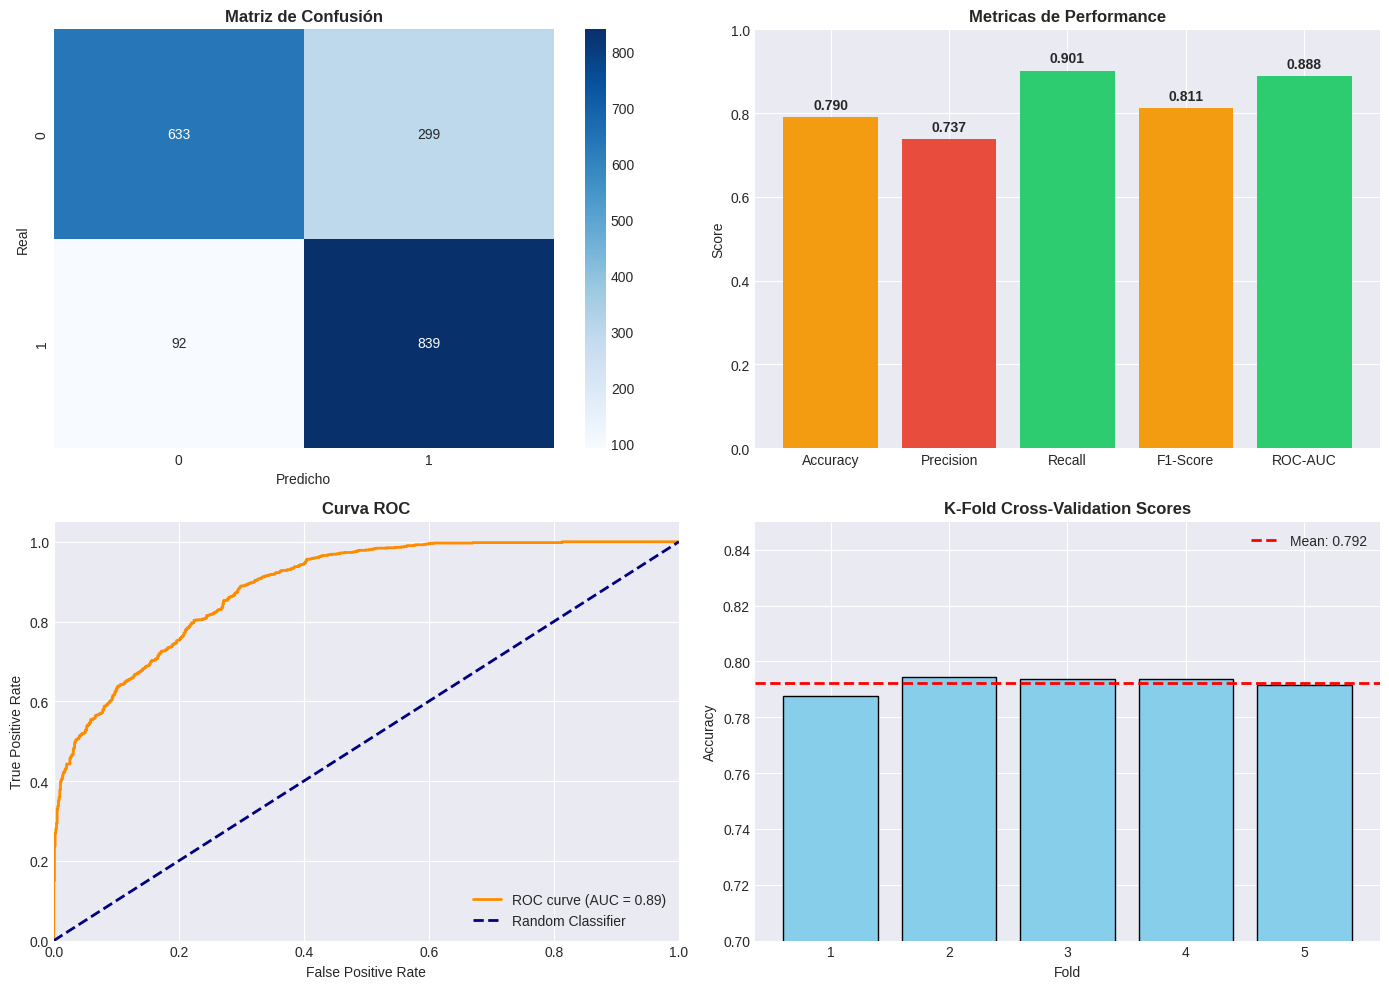


Graficas generadas exitosamente


In [25]:
# Visualizaciones finales
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Matriz de confusion
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_title('Matriz de Confusión', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Real')
axes[0, 0].set_xlabel('Predicho')

# Metricas
metricas = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
valores = [test_acc, precision, recall, f1, roc_auc]
colores = ['#2ecc71' if v > 0.85 else '#f39c12' if v > 0.75 else '#e74c3c' for v in valores]
axes[0, 1].bar(metricas, valores, color=colores)
axes[0, 1].set_title('Metricas de Performance', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_ylim([0, 1])
for i, v in enumerate(valores):
    axes[0, 1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[1, 0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
axes[1, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[1, 0].set_xlim([0.0, 1.0])
axes[1, 0].set_ylim([0.0, 1.05])
axes[1, 0].set_xlabel('False Positive Rate')
axes[1, 0].set_ylabel('True Positive Rate')
axes[1, 0].set_title('Curva ROC', fontsize=12, fontweight='bold')
axes[1, 0].legend(loc="lower right")

# K-Fold scores
axes[1, 1].bar(range(1, 6), cv_scores, color='skyblue', edgecolor='black')
axes[1, 1].axhline(cv_scores.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {cv_scores.mean():.3f}')
axes[1, 1].set_title('K-Fold Cross-Validation Scores', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Fold')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].set_ylim([0.7, 0.85])
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print("\nGraficas generadas exitosamente")

In [ ]:
print("\n[OK] FASE 5 COMPLETADA")
print("\n" + "="*80)
print("RESUMEN DEL ENTRENAMIENTO")
print("="*80)
print(f"\nPERFORMANCE FINAL:")
print(f"  - Test Accuracy:    {test_acc*100:.2f}%")
print(f"  - Test Recall:      {recall*100:.2f}% (detecta vulnerabilidades)")
print(f"  - Test ROC-AUC:     {roc_auc*100:.2f}%")
print(f"  - 5-Fold CV:        {cv_scores.mean()*100:.2f}% ± {cv_scores.std()*100:.2f}%")
print(f"  - Overfitting Gap:  {overfitting*100:.2f}%")
print(f"\nESTADO: ✅ MODELO ENTRENADO Y VALIDADO")

---
# GUARDAR ARTEFACTOS (OPCIONAL)
### Guardar modelos para usar en produccion

In [26]:
# Guardar modelos y vectorizadores
output_dir = '/content/drive/MyDrive/CVEfixes/models'  # Ajusta segun tu setup

try:
    os.makedirs(output_dir, exist_ok=True)

    # Guardar modelo
    with open(f'{output_dir}/vulnerability_detector.pkl', 'wb') as f:
        pickle.dump(model, f)

    # Guardar vectorizador
    with open(f'{output_dir}/vectorizer_detector.pkl', 'wb') as f:
        pickle.dump(tfidf_vectorizer, f)

    # Guardar encoder
    with open(f'{output_dir}/language_encoder.pkl', 'wb') as f:
        pickle.dump(lang_encoder, f)

    print(f"[OK] Modelos guardados en {output_dir}")
except Exception as e:
    print(f"[WARNING] No se pudieron guardar los modelos: {e}")
    print("Esto es normal si ejecutas en Colab sin Google Drive montado")

[OK] Modelos guardados en /content/drive/MyDrive/CVEfixes/models


---
# INFERENCIA - Hacer predicciones con codigo nuevo

In [30]:
# Ejemplo de inferencia con nuevo codigo
print("\n" + "="*80)
print("EJEMPLO DE INFERENCIA")
print("="*80)

# Ejemplos de prueba
ejemplos = [
    ("int x = 5; x++;", "c++", "Seguro"),
    ("char buffer[10]; strcpy(buffer, user_input);", "c++", "Vulnerable - Buffer Overflow"),
    ("x = 10; print(x)", "python", "Seguro"),
    ("query = 'SELECT * FROM users WHERE id = ' + user_input", "python", "Vulnerable - SQL Injection"),
]

for codigo, lenguaje, etiqueta_real in ejemplos:
    print(f"\nCodigo: {codigo[:50]}...")
    print(f"Lenguaje: {lenguaje}")
    print(f"Etiqueta real: {etiqueta_real}")

    # Vectorizar
    features = tfidf_vectorizer.transform([codigo])
    lang_encoded = lang_encoder.transform([lenguaje])
    features_combined = np.column_stack([features.toarray(), lang_encoded])

    # Prediccion
    pred = model.predict(features_combined)[0]
    prob = model.predict_proba(features_combined)[0]

    pred_label = "Vulnerable" if pred == 1 else "Seguro"
    confianza = prob[pred]

    print(f"Prediccion: {pred_label} (Confianza: {confianza*100:.1f}%)")
    print(f"Probabilidades: Seguro={prob[0]:.3f}, Vulnerable={prob[1]:.3f}")
    print("-" * 80)


EJEMPLO DE INFERENCIA

Codigo: int x = 5; x++;...
Lenguaje: c++
Etiqueta real: Seguro
Prediccion: Vulnerable (Confianza: 56.5%)
Probabilidades: Seguro=0.435, Vulnerable=0.565
--------------------------------------------------------------------------------

Codigo: char buffer[10]; strcpy(buffer, user_input);...
Lenguaje: c++
Etiqueta real: Vulnerable - Buffer Overflow


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      |

Prediccion: Vulnerable (Confianza: 63.5%)
Probabilidades: Seguro=0.365, Vulnerable=0.635
--------------------------------------------------------------------------------

Codigo: x = 10; print(x)...
Lenguaje: python
Etiqueta real: Seguro
Prediccion: Vulnerable (Confianza: 54.1%)
Probabilidades: Seguro=0.459, Vulnerable=0.541
--------------------------------------------------------------------------------

Codigo: query = 'SELECT * FROM users WHERE id = ' + user_i...
Lenguaje: python
Etiqueta real: Vulnerable - SQL Injection
Prediccion: Vulnerable (Confianza: 69.8%)
Probabilidades: Seguro=0.302, Vulnerable=0.698
--------------------------------------------------------------------------------


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.1s finished
